<br>

# Predicting Stock Market 

<br>

---------

    In this project, I work with the S&P500 stock market index from 1950 to 2015. This index aggregates the stock prices of 500 large companies to give information about the stock market in general. 

    I will be building a linear regression model that will use historical data (1950 to 2012) to make predictions about stock prices from 2013 to 2015. 

----------

### Imports

In [1]:
import numpy as np
import pandas as pd

from datetime import datetime

from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from math import sqrt

### Data Exploration

In [2]:
stocks = pd.read_csv('./sphist.csv', index_col = 'Date')

In [3]:
stocks.head()

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2015-12-07,2090.419922,2090.419922,2066.780029,2077.070068,4.043820e+09,2077.070068
2015-12-04,2051.239990,2093.840088,2051.239990,2091.689941,4.214910e+09,2091.689941
2015-12-03,2080.709961,2085.000000,2042.349976,2049.620117,4.306490e+09,2049.620117
2015-12-02,2101.709961,2104.270020,2077.110107,2079.510010,3.950640e+09,2079.510010
2015-12-01,2082.929932,2103.370117,2082.929932,2102.629883,3.712120e+09,2102.629883


**Convert the date column to Pandas date data type**

In [4]:
stocks.index = pd.to_datetime(stocks.index)

In [5]:
stocks.dtypes

Open         float64
High         float64
Low          float64
Close        float64
Volume       float64
Adj Close    float64
dtype: object

In [6]:
stocks.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16590 entries, 2015-12-07 to 1950-01-03
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       16590 non-null  float64
 1   High       16590 non-null  float64
 2   Low        16590 non-null  float64
 3   Close      16590 non-null  float64
 4   Volume     16590 non-null  float64
 5   Adj Close  16590 non-null  float64
dtypes: float64(6)
memory usage: 907.3 KB


In [7]:
stocks.describe()

,Open,High,Low,Close,Volume,Adj Close
count,16590.000000,16590.000000,16590.000000,16590.000000,1.659000e+04,16590.000000
mean,482.570941,485.624237,479.367501,482.692491,7.940099e+08,482.692491
std,554.889186,558.186049,551.367625,555.007904,1.456582e+09,555.007904
min,16.660000,16.660000,16.660000,16.660000,6.800000e+05,16.660000
25%,83.860001,84.594997,83.139997,83.860001,7.610000e+06,83.860001
50%,144.049995,145.294998,143.105004,144.264999,7.170500e+07,144.264999
75%,950.722488,956.665024,941.969986,950.797500,7.866750e+08,950.797500
max,2130.360107,2134.719971,2126.060059,2130.820068,1.145623e+10,2130.820068


**Sort the stocks DataFrame by the date column asc**

In [8]:
stocks = stocks.sort_index()
stocks.head()

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
1950-01-03,16.66,16.66,16.66,16.66,1260000.0,16.66
1950-01-04,16.85,16.85,16.85,16.85,1890000.0,16.85
1950-01-05,16.93,16.93,16.93,16.93,2550000.0,16.93
1950-01-06,16.98,16.98,16.98,16.98,2010000.0,16.98
1950-01-09,17.08,17.08,17.08,17.08,2520000.0,17.08


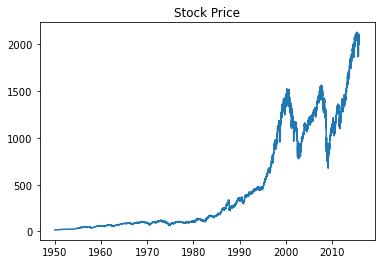

<Figure size 1080x1080 with 0 Axes>

In [9]:
plt.plot(stocks.index, stocks['Close'])
plt.title('Stock Price')
plt.figure(figsize=(15, 15))
plt.show()

**Keep a copy of this stocks dataframe in case its needed**

In [10]:
stocks_original = stocks

### Feature Engineering

I'll create 4 new columns that should offer very useful information to the linear regression model when predicting prices for stocks

-----

**1. Average price of stocks from 5 previous days**

In [11]:
stocks['5 Day Avg'] = stocks['Close'].rolling(5).mean()

**2. Average price of stocks from previous 30 days**

In [12]:
stocks['30 Day Avg'] = stocks['Close'].rolling(30).mean()

**3. Standard Deviation of stocks from previous 5 days**

In [13]:
stocks['5 Day StdDev'] = stocks['Close'].rolling(5).std()

**4. Standard Deviation of stocks from previous 30 days**

In [14]:
stocks['30 Day StdDev'] = stocks['Close'].rolling(30).std()

Shift this newly created column by 1 to avoid leaking information from features to targets (future leakage in this case)

In [15]:
new_cols = ['5 Day Avg', '30 Day Avg', '5 Day StdDev', '30 Day StdDev']

In [16]:
stocks[new_cols] = stocks[new_cols].shift(1)

Now drop first 30 rows of data since they will have NaN values for the new columns

In [17]:
stocks = stocks.dropna()

In [18]:
stocks.head()

,Open,High,Low,Close,Volume,Adj Close,5 Day Avg,30 Day Avg,5 Day StdDev,30 Day StdDev
Date,,,,,,,,,,
1950-02-15,17.059999,17.059999,17.059999,17.059999,1730000.0,17.059999,17.204,16.976667,0.084440,0.197978
1950-02-16,16.990000,16.990000,16.990000,16.990000,1920000.0,16.990000,17.170,16.990000,0.103442,0.189191
1950-02-17,17.150000,17.150000,17.150000,17.150000,1940000.0,17.150000,17.126,16.994667,0.126413,0.187336
1950-02-20,17.200001,17.200001,17.200001,17.200001,1420000.0,17.200001,17.100,17.002000,0.096696,0.189016
1950-02-21,17.170000,17.170000,17.170000,17.170000,1260000.0,17.170000,17.092,17.009333,0.082886,0.192371


----------
## Stock Price Prediction: Linear Regression
----------

In [19]:
def train_regressor(features, train_X, train_y, test_X, test_y):
    
    train_X_subset = train_X[features]
    test_X_subset = test_X[features]
    
    model = LinearRegression()
    model.fit(train_X_subset, train_y)
    
    predictions = model.predict(test_X_subset)
    predictions_pd = pd.Series(predictions, index = test_y.index)
    rmse = sqrt(mean_squared_error(predictions, test_y))

    return rmse, predictions_pd

**Split train and test data**
  <br>
  <br>  **train**: 1950 to 2012
  <br>  **test**:  2013 to 2015

In [20]:
train_X = stocks.loc['1950':'2012']
test_X = stocks.loc['2013':'2015']

**Seperate Target Column, Remove columns with information about price**

In [21]:
train_y = train_X['Close']
test_y = test_X['Close']

train_X = train_X[new_cols]
test_X = test_X[new_cols]

### Error analysis

For error comparison, I'll create three different DataFrames to fit the model to. 
One containing only the 5 day avg and stdev. One containing only the 30 day avg and stddev. And one with all 4 columns (which is just the original train_X dataframe).

In [22]:
rmse_5, _ = train_regressor(['5 Day Avg', '5 Day StdDev'], train_X, train_y, test_X, test_y)
rmse_30, _ = train_regressor(['30 Day Avg', '30 Day StdDev'], train_X, train_y, test_X, test_y)
rmse_both, predictions_pd = train_regressor(new_cols, train_X, train_y, test_X, test_y)

In [23]:
rmse_5

22.118550113003344

In [24]:
rmse_30

41.08866231900498

In [25]:
rmse_both

22.21109303853851

**Results**
<br><br>
From the error reports above, it would appear that using the 5 day avg and 5 day std dev as features produces the best predictions, followed closely by using both 5 and 30 day calculations. Using only the 30 day calculations provided the worst performance.

**A visual representation of predictions compared to actual stock prices**

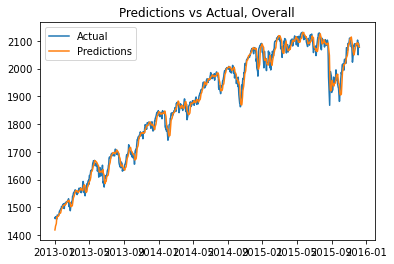

In [44]:
plt.plot(test_y, label = 'Actual')
plt.plot(predictions_pd, label = 'Predictions')
plt.title('Predictions vs Actual, Overall')
plt.legend()
plt.show()

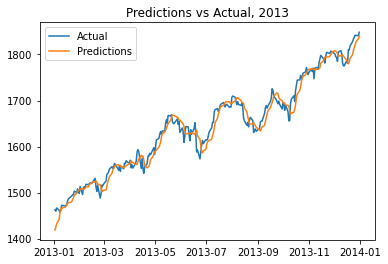

In [45]:
plt.plot(test_y.loc['2013'], label = 'Actual')
plt.plot(predictions_pd.loc['2013'], label = 'Predictions')
plt.title('Predictions vs Actual, 2013')
plt.legend()
plt.show()